In [1]:
# import modules for data import and editing
import json
import pandas as pd
import gzip
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import time

# import modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#import modules for text analysis
import spacy


pd.set_option("display.max_columns", None)

In [2]:
def import_json_gz(file,limit = 1000000):
    '''
    Function opens and loads a gziped json file and returns a selected number of rows from that file in tabular form.
    Max number of entries: 1 million
    Returns: Pandas Dataframe
    '''
    if limit > 1000000:
        return 'Sorry, your limit is to high. Please choose a number <= 1000000'
    data = []
    count = 0
    with gzip.open(file) as f:
        for l in f:
            data_dict = json.loads(l.strip())
            data.append(data_dict)
            count += 1
            if count == limit:
                break
    return pd.DataFrame(data)

In [3]:
# files that will be used
# file_meta contains meta data for books
file_meta = 'goodreads_books_meta.json.gz'
# file_review contains review texts and additional information
file_reviews = 'goodreads_reviews_spoiler.json.gz'
# file_genre contains genre of books
file_genre = 'goodreads_book_genres_initial.json.gz'

In [4]:
#load a subset of the books meta data to get an idea of what features to extract
df_meta = import_json_gz(file_meta, 10000)

In [5]:
df_meta.head()

,asin,authors,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,isbn,isbn13,kindle_asin,language_code,link,num_pages,popular_shelves,publication_day,publication_month,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,title,title_without_series,url,work_id
0,,"[{'author_id': '604031', 'role': ''}]",4.00,5333265,US,,,Paperback,https://images.gr-assets.com/books/1310220028m...,false,0312853122,9780312853129,,,https://www.goodreads.com/book/show/5333265-w-...,256,"[{'count': '3', 'name': 'to-read'}, {'count': ...",1,9,1984,St. Martin's Press,3,[],[],1,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,https://www.goodreads.com/book/show/5333265-w-...,5400751
1,,"[{'author_id': '626222', 'role': ''}]",3.23,1333909,US,"Anita Diamant's international bestseller ""The ...",Abridged,Audio CD,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743509986,9780743509985,B000FC0PBC,,https://www.goodreads.com/book/show/1333909.Go...,,"[{'count': '2634', 'name': 'to-read'}, {'count...",1,10,2001,Simon & Schuster Audio,10,[],"[8709549, 17074050, 28937, 158816, 228563, 112...",6,Good Harbor,Good Harbor,https://www.goodreads.com/book/show/1333909.Go...,1323437
2,B00071IKUY,"[{'author_id': '10333', 'role': ''}]",4.03,7327624,US,Omnibus book club edition containing the Ladie...,Book Club Edition,Hardcover,https://images.gr-assets.com/books/1304100136m...,false,,,,eng,https://www.goodreads.com/book/show/7327624-th...,600,"[{'count': '58', 'name': 'to-read'}, {'count':...",,,1987,"Nelson Doubleday, Inc.",140,[189911],"[19997, 828466, 1569323, 425389, 1176674, 2627...",7,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,8948723
3,,"[{'author_id': '9212', 'role': ''}]",3.49,6066819,US,Addie Downs and Valerie Adler were eight when ...,,Hardcover,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743294297,9780743294294,B002ENBLOK,eng,https://www.goodreads.com/book/show/6066819-be...,368,"[{'count': '7615', 'name': 'to-read'}, {'count...",14,7,2009,Atria Books,51184,[],"[6604176, 6054190, 2285777, 82641, 7569453, 70...",3282,Best Friends Forever,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,6243154
4,,"[{'author_id': '149918', 'role': ''}]",3.40,287140,US,,,,https://images.gr-assets.com/books/1413219371m...,false,0850308712,9780850308716,,,https://www.goodreads.com/book/show/287140.Run...,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,,,,15,[],[],5,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...,https://www.goodreads.com/book/show/287140.Run...,278577


We consider the following features as usful for EDA and feature engineering:  
    * book_id  
    * title  
    * description  
    * publication_year, publication_month, publication_day  
    * average_rating  
    * ratings_count  
    * num_pages  

In [6]:
def check_features(features, dataset):
    '''
    simple way to check if selected features are in a dataset
    '''
    for f in features:
        if f not in dataset.columns:
            return f'{f} is not a valid column name'
    return 'Good to go!'

In [7]:
#generator to open json.gzip files
# yields single lines
def get_book(file):
    '''
    Generator will yield lines of the passed file
    '''
    with gzip.open(file, 'r') as f:
        for l in f:
            yield l

# fetch features
def fetch_features(file, features, book_list):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a dictionary.
    
    File: json.gzip file you want to scan
    
    Features: features to extract
    
    book_list: set of book_ids
    '''
    
    feature_dict = defaultdict(list)    
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        
        try:
            if book_id in book_list:
                for f in features:
                    feature_dict[f].append(book_dict.get(f))
        except: 
            pass
        
    return feature_dict

In [8]:
def fetch_one_feature(file, f):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a list.
    '''
    
    feature = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        feature.append(book_dict.get(f))
    
    return feature

In [297]:
book_ids =fetch_one_feature(file_reviews, 'book_id')
book_ids_unique = book_ids
print(f'Number of reviews: {len(book_ids)}')
book_ids=set(book_ids)
print(f'The dataset contains reviews for {len(book_ids2)} books.')

1378033it [00:44, 30897.07it/s]


Number of reviews: 1378033
The dataset contains reviews for 25475 books.


In [12]:
# get book ids from review file
# features: list containing features we want to extract from the book-meta data file
features = ['book_id', 'title', 'description', 'publication_year', 'publication_month', 
            'publication_day', 'average_rating', 'ratings_count', 'num_pages']
check_features(features, df_meta)

'Good to go!'

In [13]:
book_meta_features = pd.DataFrame.from_dict(fetch_features(file_meta, features, book_ids))

2360655it [03:42, 10626.18it/s]


In [15]:
book_meta_features.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,,,,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3,5,4.36,1759,
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8,1,4.04,6049,400
9,9469517,Mercy,,2009,2,1,3.64,3559,226


In [16]:
book_meta_features.shape

(25475, 9)

In [29]:
book_meta_features.isna().sum()

book_id              0
title                0
description          0
publication_year     0
publication_month    0
publication_day      0
average_rating       0
ratings_count        0
num_pages            0
dtype: int64

Going back to data source, we figured out that missing values are empty strings (''). We will use the replace function to replace missing values with np.nan.

In [193]:
# replace '' (missing values) with na
book_meta_features2 = book_meta_features.copy()
book_meta_features2 = book_meta_features2.replace('', np.nan)
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10.0,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7.0,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6.0,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6.0,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3.0,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3.0,5,4.36,1759,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1.0,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8.0,1,4.04,6049,400
9,9469517,Mercy,NaN,2009,2.0,1,3.64,3559,226


In [194]:
#missing values
df_b_m = pd.DataFrame({
    'missing_count':book_meta_features2.isnull().sum()
})
df_b_m['missing_rel'] = round(df_b_m.missing_count/len(book_meta_features2),2)*100
df_b_m

,missing_count,missing_rel
book_id,0,0.0
title,0,0.0
description,305,1.0
publication_year,3084,12.0
publication_month,3605,14.0
publication_day,4183,16.0
average_rating,1,0.0
ratings_count,1,0.0
num_pages,2002,8.0


In [195]:
# what is the data type of the different features
# in the original data it looks like all features are saved as strings
book_meta_features.dtypes

book_id               object
title                 object
description           object
publication_year      object
publication_month    float64
publication_day       object
average_rating        object
ratings_count         object
num_pages             object
dtype: object

In [196]:
# replace average_rating, rating_count and num_pages as int
to_transform = ['publication_year','publication_month', 'publication_day','average_rating','ratings_count', 'num_pages' ]
for f in to_transform:
    book_meta_features2[f]=pd.to_numeric(book_meta_features2[f], errors='coerce')

In [197]:
book_meta_features2.dtypes

book_id               object
title                 object
description           object
publication_year     float64
publication_month    float64
publication_day      float64
average_rating       float64
ratings_count        float64
num_pages            float64
dtype: object

In [198]:
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014.0,10.0,6.0,3.71,1525.0,351.0
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017.0,7.0,25.0,4.19,693.0,384.0
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008.0,6.0,1.0,3.41,3852.0,210.0
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011.0,6.0,7.0,3.98,252.0,8.0
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010.0,3.0,23.0,3.88,1675.0,245.0
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023.0,340.0
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017.0,3.0,5.0,4.36,1759.0,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012.0,1.0,1.0,4.10,289.0,402.0
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011.0,8.0,1.0,4.04,6049.0,400.0
9,9469517,Mercy,NaN,2009.0,2.0,1.0,3.64,3559.0,226.0


In [199]:
book_meta_features2['weighted_average_rating']=book_meta_features2.average_rating*book_meta_features2.ratings_count

In [200]:
book_meta_features2.head(2)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014.0,10.0,6.0,3.71,1525.0,351.0,5657.75
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017.0,7.0,25.0,4.19,693.0,384.0,2903.67


In [229]:
genre = import_json_gz2(file_genre)

In [304]:
def fetch_genre(file, book_list):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a dictionary.
    
    File: json.gzip file you want to scan
    
    Features: features to extract
    
    book_list: set of book_ids
    '''
    
    book_genres = []    
    missing_genre = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        book_genre = book_dict.get('genres')
        try:
            if book_id in book_list:
                book_genres.append(book_dict) 
                if not book_genre:
                    missing_genre.append(book_id)
        except: 
            pass
        
    return book_genres, missing_genre

In [305]:
genre, missing_genre = fetch_genre(file_genre,book_ids)

2360655it [00:18, 128188.21it/s]


In [308]:
missing_genre

['16148398']

In [306]:
df_genre = pd.DataFrame(genre)

In [307]:
df_genre.head()

,book_id,genres
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'..."
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,..."
2,2741853,"{'romance': 555, 'fiction': 61}"
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ..."
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri..."


In [285]:
df_genre.shape

(25475, 3)

In [279]:
# function to get key from dictionary with highest value
# returns None if dictionary is empty and max() will cause an error
def get_genre(x):
    try:
        a= max(x.items(), key=operator.itemgetter(1))[0]
        return a
    except:
        return np.nan

In [286]:
df_genre['best_genre'] = df_genre['genres'].apply(lambda x:get_genre(x))


In [287]:
df_genre.head()

,book_id,genres,best_genre
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'...",young-adult
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,...",romance
2,2741853,"{'romance': 555, 'fiction': 61}",romance
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ...",fiction
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri...",romance


In [288]:
df_genre.isnull().sum()

book_id       0
genres        0
best_genre    1
dtype: int64

In [290]:
# identify book with missing genre
df_missing_genre = df_genre[df_genre.best_genre.isnull()]
df_missing_genre

,book_id,genres,best_genre
16474,16148398,{},NaN


In [292]:
missing_book = book_meta_features2[book_meta_features2.book_id == '16148398']
missing_book

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating
16474,16148398,Saga #1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We seem to have no infomration but the title for the book with the missing genre. Check how often this book was reviewd by using the book ids.

In [302]:
i = 0
for book in book_ids_unique:
    if book == '16148398':
        i += 1
print(f' The book "Saga #1" was reviewed {i} time(s)')

 The book "Saga #1" was reviewed 1 time(s)


As this book was only reviewed once, we will drop this book.

In [303]:
books_to_drop = ['16148398']

In [ ]:
stats.items()

In [244]:
genre.shape

(25475, 2)

In [ ]:
df_no_spoiler = df[df['has_spoiler']==False]
#df_spoiler = df[df['has_spoiler']==True]

In [9]:
df_spoiler.shape

(6418, 7)

In [10]:
len(set(df_spoiler.user_id))

1060

In [11]:
len(set(df_spoiler.book_id))

4649

In [14]:
sen = df_spoiler.review_sentences

In [21]:
length=[]
for s in sen:
    length.append(len(s))

(array([ 580., 1201., 1141.,  880.,  633.,  475.,  384.,  268.,  214.,
         109.,  118.,   92.,   74.,   58.,   37.,   23.,   27.,   14.,
          18.,   12.,   11.,    8.,    6.,    8.,    6.,    6.,    4.,
           0.,    8.,    3.]),
 array([  1. ,   5.9,  10.8,  15.7,  20.6,  25.5,  30.4,  35.3,  40.2,
         45.1,  50. ,  54.9,  59.8,  64.7,  69.6,  74.5,  79.4,  84.3,
         89.2,  94.1,  99. , 103.9, 108.8, 113.7, 118.6, 123.5, 128.4,
        133.3, 138.2, 143.1, 148. ]),
 <BarContainer object of 30 artists>)

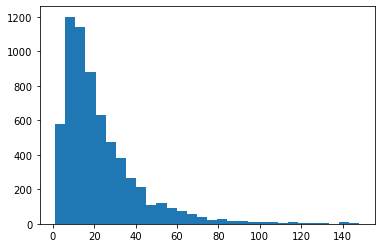

In [25]:
plt.hist(length, bins = 30)


(array([4.0448e+04, 1.9782e+04, 1.0160e+04, 6.7910e+03, 4.6830e+03,
        3.2870e+03, 2.4240e+03, 1.7340e+03, 1.2790e+03, 7.7100e+02,
        6.3100e+02, 4.8000e+02, 2.9700e+02, 2.0800e+02, 1.5900e+02,
        1.1600e+02, 7.7000e+01, 5.9000e+01, 4.4000e+01, 2.3000e+01,
        2.7000e+01, 2.8000e+01, 2.3000e+01, 1.6000e+01, 7.0000e+00,
        6.0000e+00, 1.2000e+01, 4.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([  1. ,   5.9,  10.8,  15.7,  20.6,  25.5,  30.4,  35.3,  40.2,
         45.1,  50. ,  54.9,  59.8,  64.7,  69.6,  74.5,  79.4,  84.3,
         89.2,  94.1,  99. , 103.9, 108.8, 113.7, 118.6, 123.5, 128.4,
        133.3, 138.2, 143.1, 148. ]),
 <BarContainer object of 30 artists>)

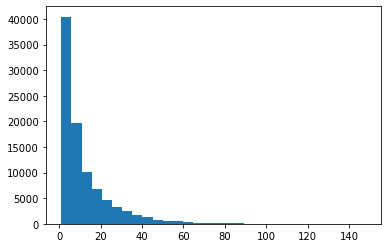

In [28]:
sen2 = df_no_spoiler.review_sentences
length2=[]
for s in sen2:
    length2.append(len(s))
plt.hist(length2, bins = 30)

In [29]:
print(np.mean(length))
print(np.mean(length2))

22.585073231536303
11.752206620931375
